# Import Libraries

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from google.colab import drive
import scipy.stats as stats
from io import StringIO
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras

# Load Data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = !find "/content/drive/My Drive/" -name "BIMBOA_MX.csv"

In [ ]:
df = pd.read_csv(path[0])

# Basic Understanding of Data (Metadata)

In [ ]:
def generate_dataframe_report(df):
    # Ensure date columns are treated correctly
    for col in df.select_dtypes(include=['object', 'string']):
        try:
            df[col] = pd.to_datetime(df[col])
        except ValueError:
            continue  # Skip columns that cannot be converted to datetime

    # Gathering information
    shape_info = f"Shape: {df.shape[0]} rows, {df.shape[1]} columns"
    dtypes_info = df.dtypes.to_string()
    column_names = ", ".join(df.columns)

    # Generating a buffer for the concise summary
    buffer = StringIO()
    df.info(buf=buffer)
    info_summary = buffer.getvalue()

    # Summary statistics for numeric columns
    describe_info = df.describe().to_string()

    # Column Ranges
    column_ranges = []
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            col_range = f"{df[col].min()} to {df[col].max()}"
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            col_range = f"{df[col].min().strftime('%d-%B-%Y')} to {df[col].max().strftime('%d-%B-%Y')}"
        else:
            col_range = "N/A"
        column_ranges.append(f"{col}: {col_range}")
    column_ranges_info = "\n".join(column_ranges)

    # Combine all pieces into a single report string
    report = (
        "DataFrame Properties Report\n"
        "----------------------------\n"
        f"{shape_info}\n\n"
        "Column Names:\n"
        f"{column_names}\n\n"
        "Data Types:\n"
        f"{dtypes_info}\n\n"
        "Info Summary:\n"
        f"{info_summary}\n"
        "Summary Statistics (for numeric columns):\n"
        f"{describe_info}\n\n"
        "Column Ranges:\n"
        f"{column_ranges_info}"
    )
    # Print the overview report of the dataframe
    print(report)


In [ ]:
generate_dataframe_report(df)

DataFrame Properties Report
----------------------------
Shape: 6115 rows, 7 columns

Column Names:
Date, Open, High, Low, Close, Adj Close, Volume

Data Types:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64

Info Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6115 entries, 0 to 6114
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6115 non-null   datetime64[ns]
 1   Open       6115 non-null   float64       
 2   High       6115 non-null   float64       
 3   Low        6115 non-null   float64       
 4   Close      6115 non-null   float64       
 5   Adj Close  6115 non-null   float64       
 6   Volume     6115 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 334.5 KB

Summary Statistics (for num

# Exploratory Data Analysis

## Time Series Visualization of Variables

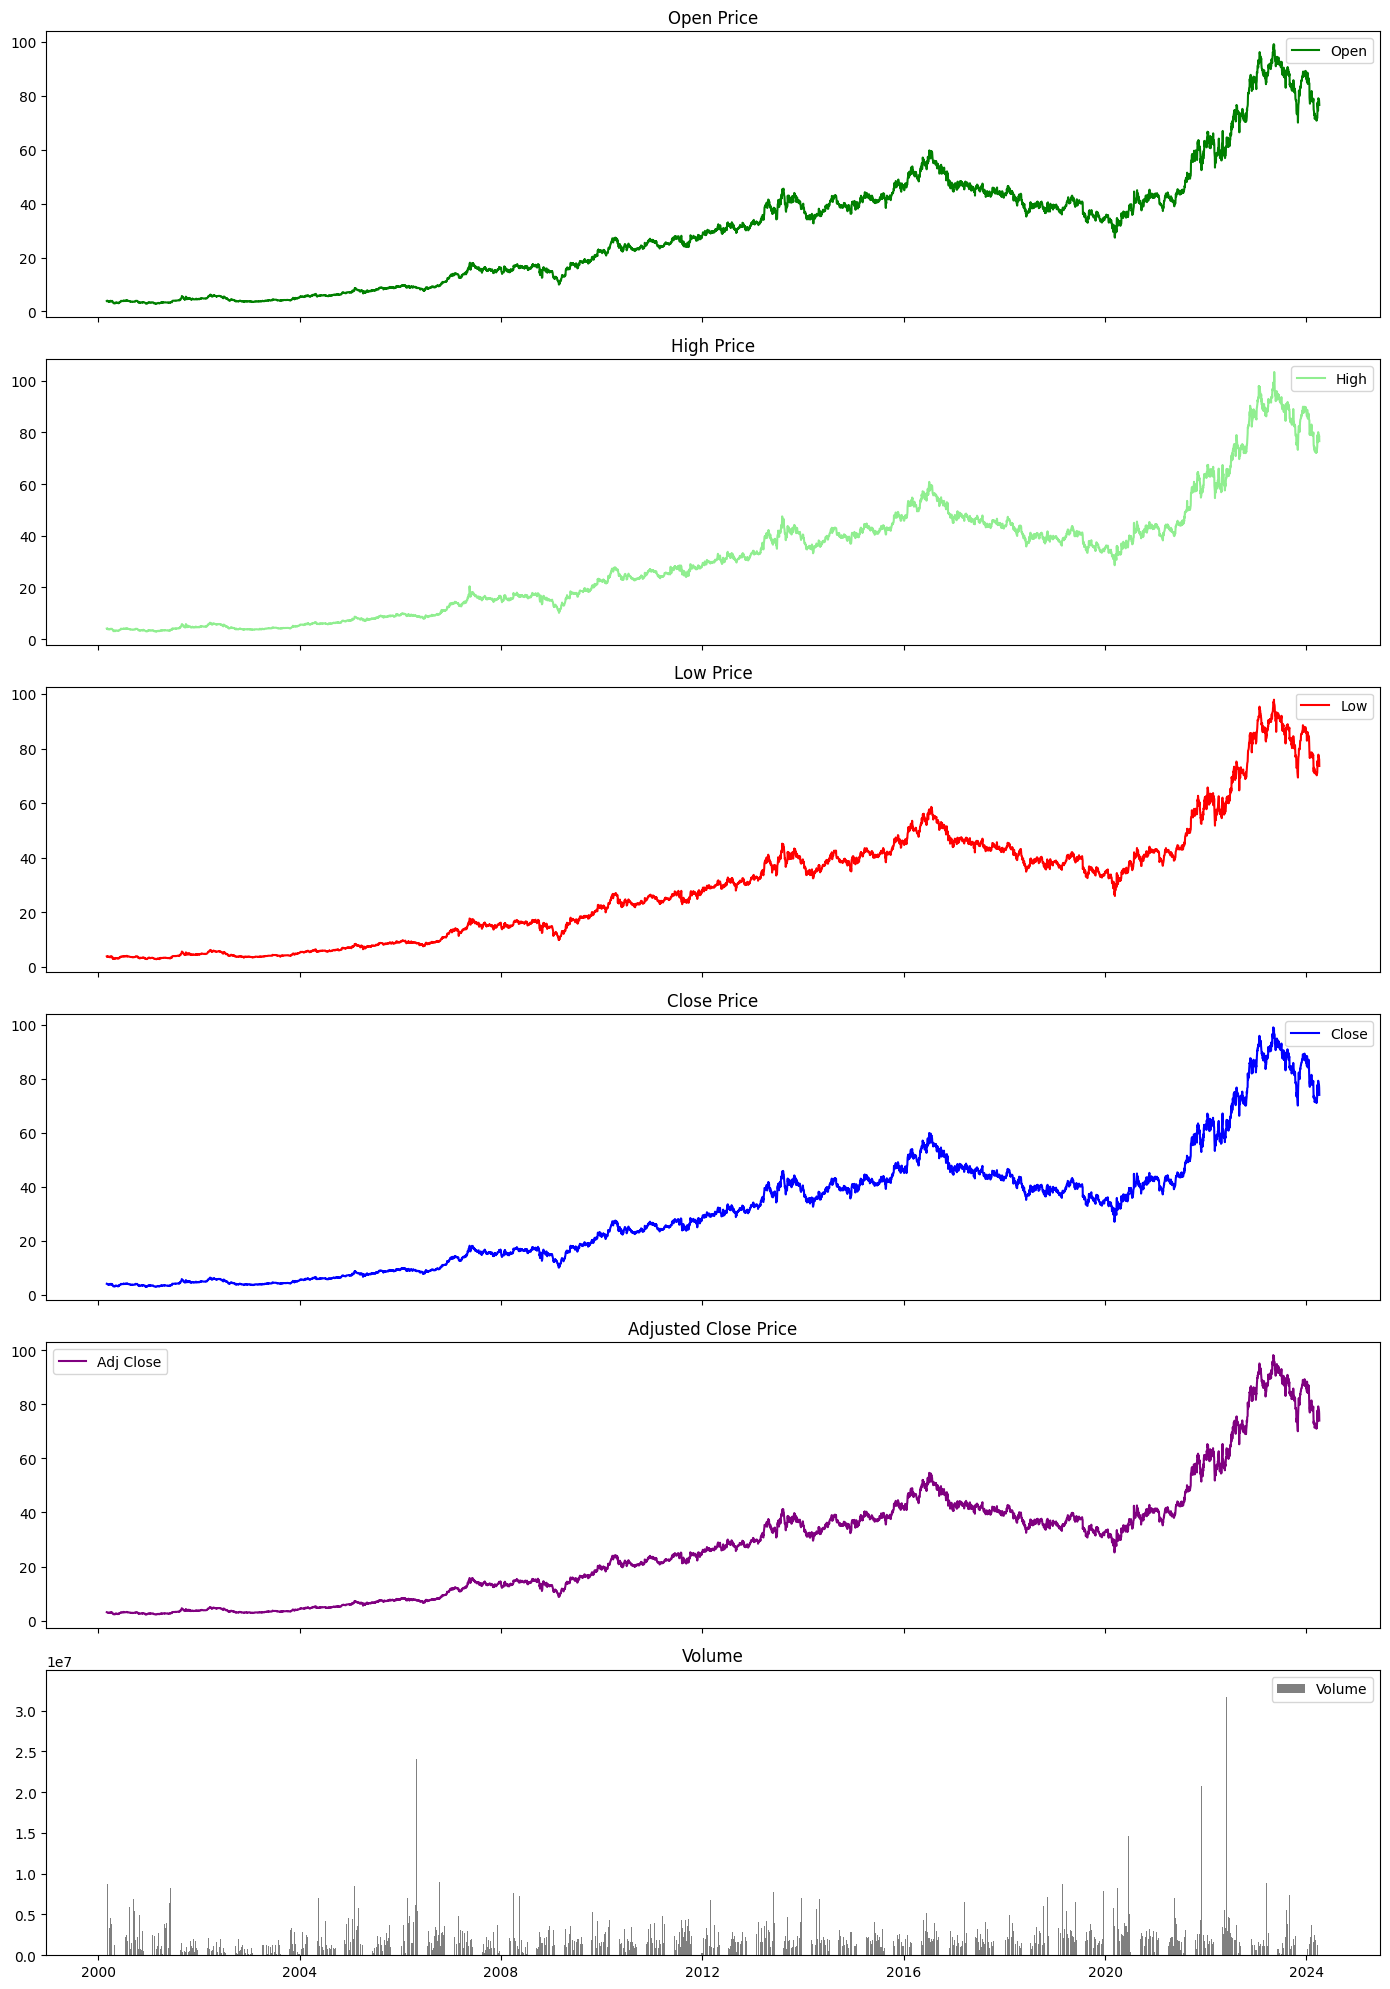

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Creating subplots for each variable
fig, axs = plt.subplots(6, 1, figsize=(14, 20), sharex=True)

# Plotting each variable on its subplot
axs[0].plot(df.index, df['Open'], label='Open', color='green')
axs[0].set_title('Open Price')
axs[0].legend()

axs[1].plot(df.index, df['High'], label='High', color='lightgreen')
axs[1].set_title('High Price')
axs[1].legend()

axs[2].plot(df.index, df['Low'], label='Low', color='red')
axs[2].set_title('Low Price')
axs[2].legend()

axs[3].plot(df.index, df['Close'], label='Close', color='blue')
axs[3].set_title('Close Price')
axs[3].legend()

axs[4].plot(df.index, df['Adj Close'], label='Adj Close', color='purple')
axs[4].set_title('Adjusted Close Price')
axs[4].legend()

axs[5].bar(df.index, df['Volume'], label='Volume', color='gray')
axs[5].set_title('Volume')
axs[5].legend()

# Improve spacing and layout
plt.tight_layout()
plt.show()

## Trend and Seasonality Analysis

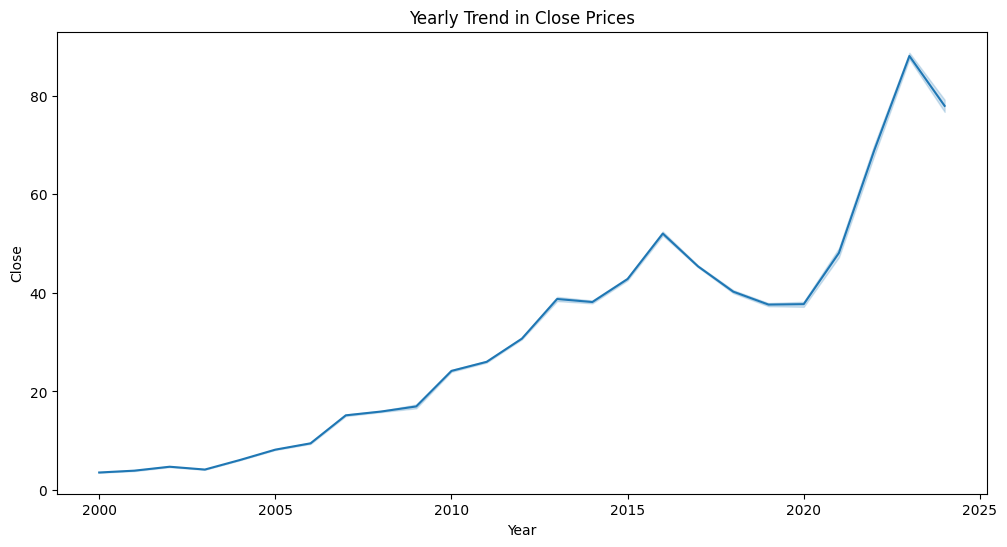

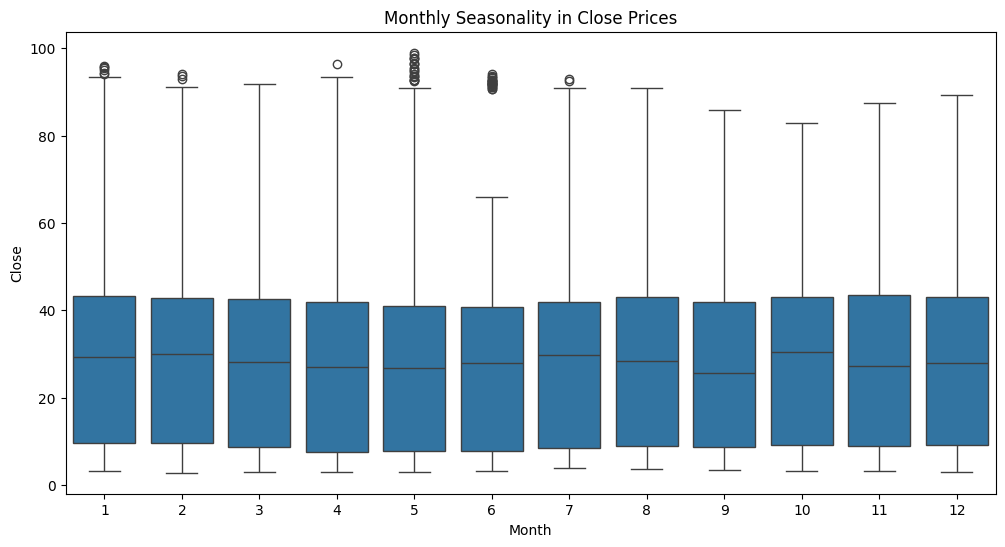

In [ ]:
# Trend analysis for 'Close' price
df['Year'] = df.index.year
df['Month'] = df.index.month

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Close', data=df, estimator='mean')
plt.title('Yearly Trend in Close Prices')
plt.show()

# Seasonality analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Close', data=df)
plt.title('Monthly Seasonality in Close Prices')
plt.show()

 # Volatility Analysis

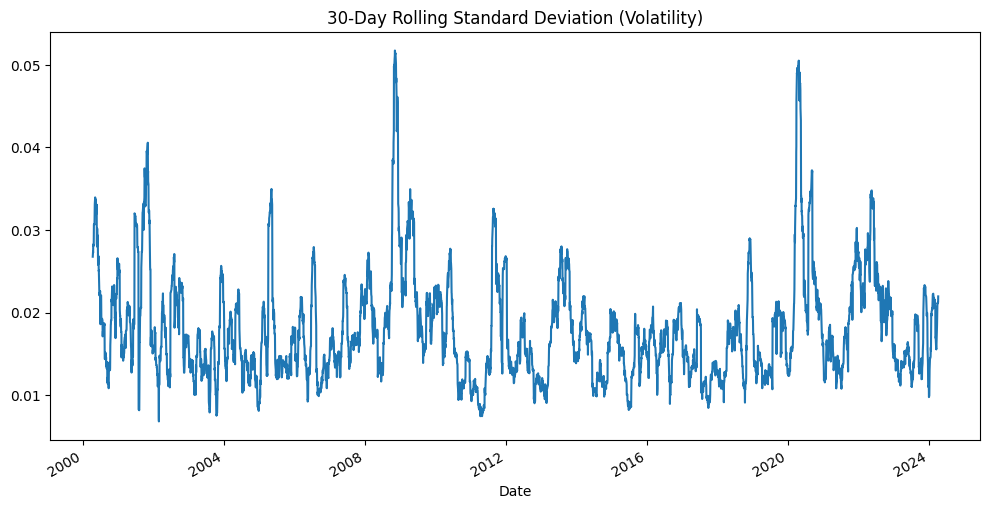

In [ ]:
# Daily returns
df['Daily_Returns'] = df['Close'].pct_change()

# Plotting volatility
plt.figure(figsize=(12, 6))
df['Daily_Returns'].rolling(window=30).std().plot()
plt.title('30-Day Rolling Standard Deviation (Volatility)')
plt.show()

# Statistical Distribution of Returns

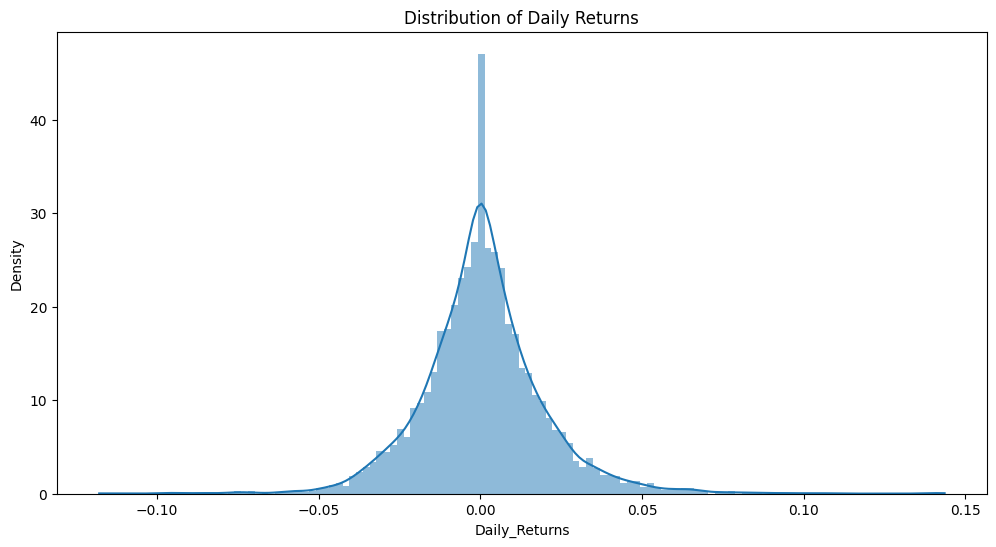

Skewness: 0.4048144050828609
Kurtosis: 4.160204260594632


In [ ]:
# Histogram of daily returns
plt.figure(figsize=(12, 6))
sns.histplot(df['Daily_Returns'].dropna(), kde=True, stat="density", linewidth=0)
plt.title('Distribution of Daily Returns')
plt.show()

# Skewness and Kurtosis
print(f"Skewness: {df['Daily_Returns'].skew()}")
print(f"Kurtosis: {df['Daily_Returns'].kurtosis()}")

# Correlation and Lag Analysis

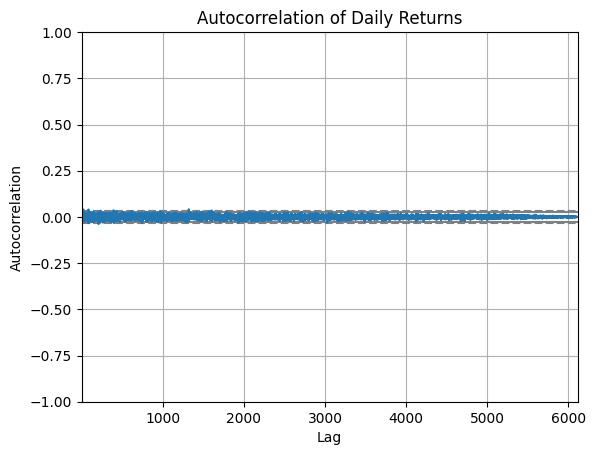

In [ ]:
# Autocorrelation of daily returns
autocorrelation_plot(df['Daily_Returns'].dropna())
plt.title('Autocorrelation of Daily Returns')
plt.show()

# Stationarity Testing

In [ ]:
result = adfuller(df['Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.115627
p-value: 0.947860


# Noise Reduction and Outlier Detection

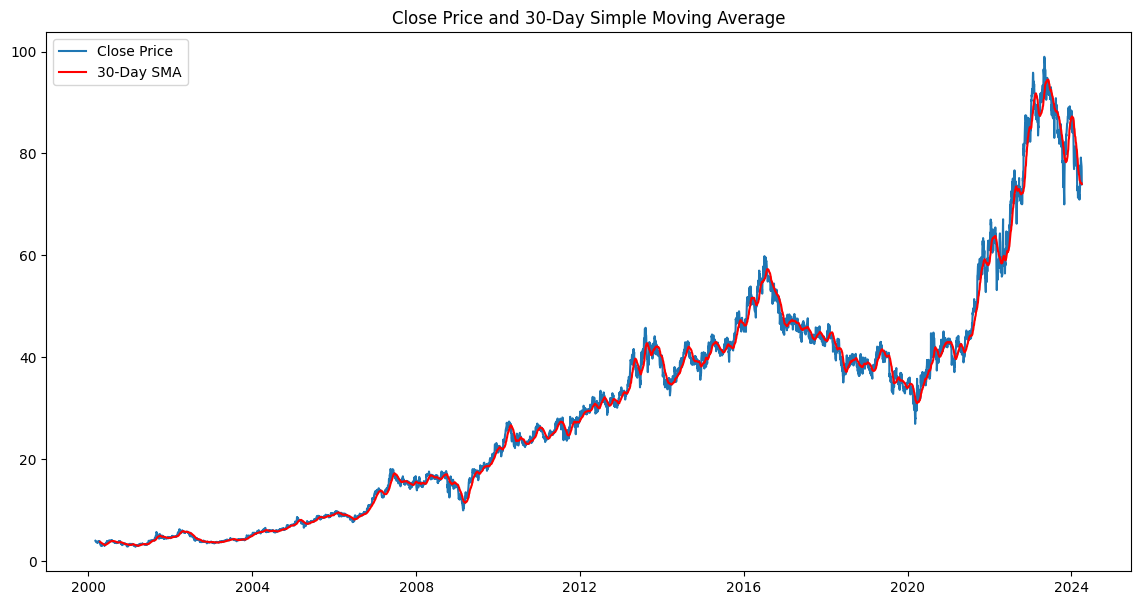

In [ ]:
# Simple Moving Average
df['SMA_30'] = df['Close'].rolling(window=30).mean()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['SMA_30'], label='30-Day SMA', color='red')
plt.title('Close Price and 30-Day Simple Moving Average')
plt.legend()
plt.show()

##Data preparation

In [ ]:
%pip install pmdarima

In [ ]:
#split data into train and test
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.model_selection import train_test_split


In [ ]:
train,test=train_test_split(np.array(df["Close"]),train_size=0.98)

# ARIMA

ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model_arima2 = ARIMA(train,order=(2,1,4))
res=model_arima2.fit()
# calculate the error
predictions2 = res.forecast(test.shape[0])[0]
#predictions = model_arima.predict(n_periods=20,return_conf_int=True)
# calculate the error
mse_arima2 =((predictions2 -test)**2).mean()
print('Test MSE: %.3f' % mse_arima2)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MSE: 40.198


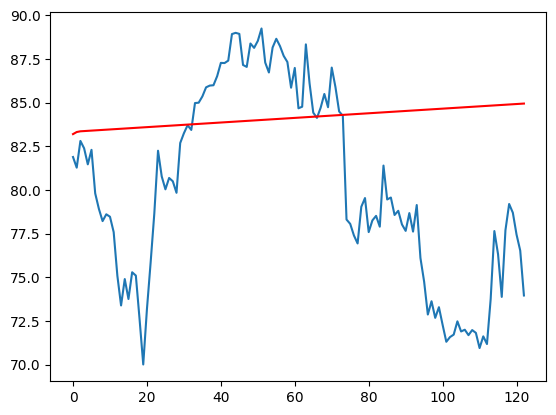

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Auto ARIMA Model

In [ ]:

model_arima=auto_arima(train,seasonal=False,trace=True)
model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11653.987, Time=10.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11756.160, Time=1.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11708.561, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11698.151, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11756.660, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11653.804, Time=3.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11656.291, Time=1.82 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11656.751, Time=3.67 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11654.774, Time=7.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11652.797, Time=1.49 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=11654.752, Time=2.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=11656.638, Time=3.15 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=11654.957, Time=0.65 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 37.027 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5992
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -5821.399
Date:                Thu, 16 May 2024   AIC                          11652.797
Time:                        03:33:22   BIC                          11686.287
Sample:                             0   HQIC                         11664.428
                               - 5992                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0132      0.007      2.012      0.044       0.000       0.026
ma.L1         -0.1035      0.007    -15.705      0.000      -0.116      -0.091
ma.L2         -0.0813      0.007    -10.899      0.000      -0.096      -0.067
ma.L3         -0.0307      0.008     -4.013      0.000      -0.046      -0.016
sigma2         0.4088      0.003    128.188      0.000       0.403       0.415
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             21687.68
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              50.81   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Get in-sample predictions
#fitted, conf_int = model_arima.predict_in_sample(return_conf_int=True)
predictions = model_arima.predict(test.shape[0])
#predictions = model_arima.predict(n_periods=20,return_conf_int=True)
# calculate the error
mse_arima =((predictions -test)**2).mean()
print('Test MSE: %.3f' % mse_arima)

Test MSE: 48.272


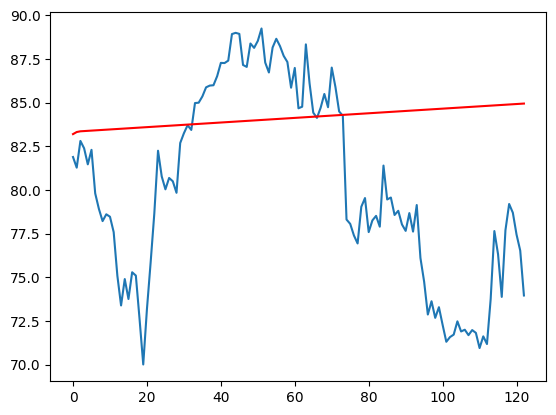

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
df.iloc[[len(train)]].index

DatetimeIndex(['2023-10-03'], dtype='datetime64[ns]', name='Date', freq=None)

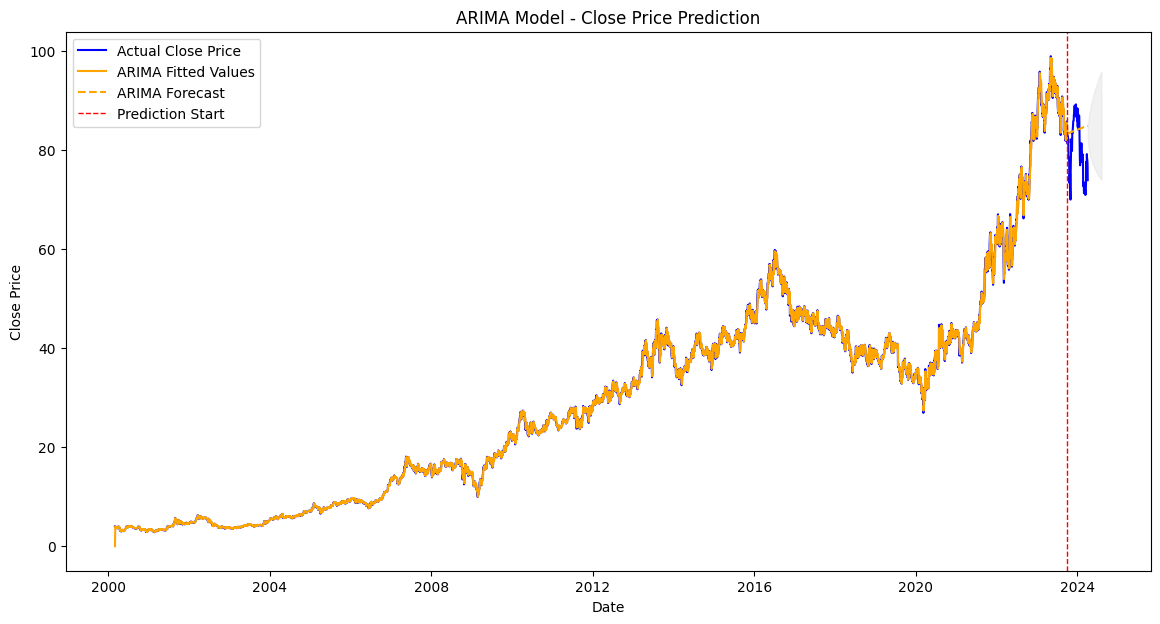

In [ ]:
# Get in-sample predictions
fitted, conf_int = model_arima.predict_in_sample(return_conf_int=True)

# Forecast future values
n_periods =test.shape[0]  #60  Number of periods for the forecast (matching ANN's prediction range)
forecast, conf_int_forecast = model_arima.predict(n_periods=n_periods, return_conf_int=True)

# Creating date range for the forecast
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_periods)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Actual Close Price', color='blue')  # Actual Close Price in blue

# Plot fitted values
plt.plot(df.iloc[:len(train)].index, fitted, color='orange', label='ARIMA Fitted Values')  # ARIMA Fitted Values in orange

# Plot forecast values
plt.plot(df.iloc[len(train):].index, forecast, color='orange', linestyle='dashed', label='ARIMA Forecast')  # ARIMA Forecast in orange dashed

# Plot confidence intervals for forecast
plt.fill_between(forecast_index, conf_int_forecast[:, 0], conf_int_forecast[:, 1], color='lightgrey', alpha=0.3)  # Confidence intervals in light grey

# Adding an asymptotic line to indicate where predictions start
plt.axvline(x=df.iloc[[len(train)]].index, color='red', linestyle='--', linewidth=1, label='Prediction Start')

plt.title('ARIMA Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#Artificial Neural Network

In [ ]:
clos=df.filter(["Close"])
datas=clos.values
ltrain=int(np.ceil(len(datas)*.98))
ltrain

5993

In [ ]:
scaler = MinMaxScaler()
ds=scaler.fit_transform(datas)

train_ds=ds[0:int(ltrain),:]
x_train2=[]
y_train2=[]

for i in range(60,len(train_ds)):
  x_train2.append(train_ds[i-60:i,0])
  y_train2.append(train_ds[i,0])

x_train2,y_train2=np.array(x_train2),np.array(y_train2)
x_train2 = np.reshape(x_train2,(x_train2.shape[0],x_train2.shape[1],1))

In [ ]:
model=keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,return_sequences=True,input_shape=(x_train2.shape[1],1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="mean_squared_error")
history= model.fit(x_train2,y_train2,epochs=10)

Epoch 1/10
186/186 [==============================] - 17s 69ms/step - loss: 0.0049
Epoch 2/10
186/186 [==============================] - 13s 72ms/step - loss: 0.0022
Epoch 3/10
186/186 [==============================] - 13s 70ms/step - loss: 0.0016
Epoch 4/10
186/186 [==============================] - 13s 71ms/step - loss: 0.0016
Epoch 5/10
186/186 [==============================] - 14s 74ms/step - loss: 0.0015
Epoch 6/10
186/186 [==============================] - 12s 64ms/step - loss: 0.0013
Epoch 7/10
186/186 [==============================] - 13s 70ms/step - loss: 0.0011
Epoch 8/10
186/186 [==============================] - 16s 87ms/step - loss: 0.0011
Epoch 9/10
186/186 [==============================] - 14s 73ms/step - loss: 0.0010
Epoch 10/10
186/186 [==============================] - 12s 62ms/step - loss: 9.3702e-04


In [ ]:
test_ds=ds[ltrain-60:,:]
x_test2 = []
y_test2= ds[ltrain:,:]

for i in range(60,len(test_ds)):
  x_test2.append(test_ds[i-60:i,0])

x_test2=np.array(x_test2)
x_test2=np.reshape(x_test2,(x_test2.shape[0],x_test2.shape[1],1))

preds=model.predict(x_test2)
preds=scaler.inverse_transform(preds)

mse=np.mean(((preds-y_test2)**2))
mse

4/4 [==============================] - 1s 30ms/step


5860.2517243073935

In [ ]:
ts.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Daily_Returns,SMA_30,preds
Date,,,,,,,,,,,
2023-10-04,82.339996,82.339996,80.529999,81.279999,81.279999,1087662,2023,10,-0.007449,84.148001,80.303299
2023-10-05,81.279999,83.199997,80.000000,82.809998,82.809998,2046930,2023,10,0.018824,83.950667,79.930450
2023-10-06,82.730003,83.010002,81.360001,82.389999,82.389999,1221730,2023,10,-0.005072,83.802000,79.683777
2023-10-09,82.360001,82.620003,81.230003,81.470001,81.470001,1289475,2023,10,-0.011166,83.587667,79.484123
2023-10-10,81.669998,82.790001,81.169998,82.300003,82.300003,2496562,2023,10,0.010188,83.390000,79.236336


<ipython-input-113-ab8e365a302a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts["preds"]=preds


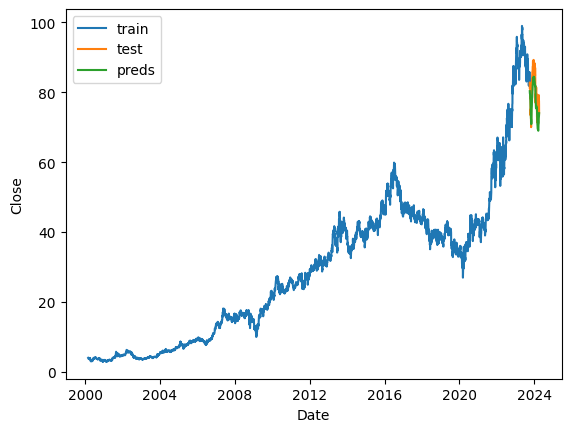

In [ ]:
tr=df[:ltrain]
ts=df[ltrain:]
ts["preds"]=preds

plt.plot(tr.index,tr["Close"])
plt.plot(ts.index,ts[["Close","preds"]])
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend(["train","test","preds"])
plt.show()

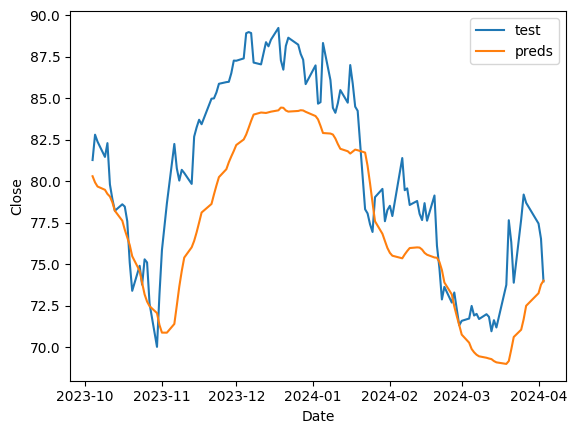

In [ ]:
plt.plot(ts.index,ts[["Close","preds"]])
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend(["test","preds"])
plt.show()

In [ ]:
mse_arimas=(predictions-test)**2
print(np.mean(mse_arimas))
#np.max(m)

48.271756794760805


In [ ]:
preds2=np.array(ts["preds"])
y_test=np.array(ts["Close"])

mse_ANN=(preds2-y_test)**2
print(np.mean(mse_ANN))

15.213061458366306
